In [1]:
from pyscf import gto,dft,scf
import matplotlib.pyplot as plt
import pickle
import numpy as np
import jax.numpy as jnp
from ase import Atoms
from ase.io import read
import xcquinox as xce
import equinox as eqx
import os, optax, jax, argparse
import faulthandler
import pandas as pd
faulthandler.enable()
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [2]:
def get_mol(atoms, basis='6-311++G**'):
    pos = atoms.positions
    spec = atoms.get_chemical_symbols()
    mol_input = [[s, p] for s, p in zip(spec, pos)]
    try:
        mol = gto.Mole(atom=mol_input, basis=atoms.info.get('basis',basis),spin=atoms.info.get('spin',0))
    except Exception:
        mol = gto.Mole(atom=mol_input, basis=atoms.info.get('basis','STO-3G'),spin=atoms.info.get('spin',0))
    return mol 

def get_rhos(rho, spin):
    rho0 = rho[0,0]
    drho = rho[0,1:4] + rho[1:4,0]
    tau = 0.5*(rho[1,1] + rho[2,2] + rho[3,3])

    if spin != 0:
        rho0_a = rho0[0]
        rho0_b = rho0[1]
        gamma_a, gamma_b = jnp.einsum('ij,ij->j',drho[:,0],drho[:,0]), jnp.einsum('ij,ij->j',drho[:,1],drho[:,1])              
        gamma_ab = jnp.einsum('ij,ij->j',drho[:,0],drho[:,1])
        tau_a, tau_b = tau
    else:
        rho0_a = rho0_b = rho0*0.5
        gamma_a=gamma_b=gamma_ab= jnp.einsum('ij,ij->j',drho[:],drho[:])*0.25
        tau_a = tau_b = tau*0.5
    return rho0_a, rho0_b, gamma_a, gamma_b, gamma_ab, tau_a, tau_b
    
def get_data_synth(xcmodel, xc_func, n=100):
    def get_rho(s, a):
        c0 = 2*(3*np.pi**2)**(1/3)
        c1 = 3/10*(3*np.pi**2)**(2/3)
        gamma = c0*s
        tau = c1*a+c0**2*s**2/8
        rho = np.zeros([len(a),6])
        rho[:, 1] = gamma
        rho[:,-1] = tau
        rho[:, 0] = 1
        return rho
    
    s_grid = jnp.concatenate([[0],jnp.exp(jnp.linspace(-10,4,n))])
    rho = []
    for s in s_grid:
        if 'MGGA' in xc_func:
            a_grid = jnp.concatenate([jnp.exp(jnp.linspace(jnp.log((s/100)+1e-8),8,n))])
        else:
            a_grid = jnp.array([0])
        rho.append(get_rho(s, a_grid))
        
    rho = jnp.concatenate(rho)
    
    fxc =  dft.numint.libxc.eval_xc(xc_func,rho.T, spin=0)[0]
 
    rho = jnp.asarray(rho)
    
    tdrho = xcmodel.get_descriptors(rho[:,0]/2,rho[:,0]/2,(rho[:,1]/2)**2,(rho[:,1]/2)**2,(rho[:,1]/2)**2,rho[:,5]/2,rho[:,5]/2, spin_scaling=True, mf=mf, dm=dm)
    


    tFxc = jnp.array(fxc)
    return tdrho[0], tFxc

def get_data(mol, xcmodel, xc_func, localnet=None):
    print('mol: ', mol.atom)
    try:
        mf = scf.UKS(mol)
    except:
        mf = dft.RKS(mol)
    mf.xc = 'PBE'
    mf.grids.level = 1
    try:
        mf.kernel()
    except Exception as e:
        print('ERROR IN CALCULATION')
        print(e)
        print('SKIPPING MOLECULE: ', mol)
        return 
    ao = mf._numint.eval_ao(mol, mf.grids.coords, deriv=2)
    dm = mf.make_rdm1()
    if len(dm.shape) == 2:
        #artificially spin-polarize
        dm = np.array([0.5*dm, 0.5*dm])
    print('New DM shape: {}'.format(dm.shape))
    print('ao.shape', ao.shape)

    if localnet.spin_scaling:
        print('spin scaling, indicates exchange network')
        rho_alpha = mf._numint.eval_rho(mol, ao, dm[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, ao, dm[1], xctype='metaGGA',hermi=True)
        fxc_a =  mf._numint.eval_xc(xc_func,(rho_alpha,rho_alpha*0), spin=1)[0]
        fxc_b =  mf._numint.eval_xc(xc_func,(rho_beta*0,rho_beta), spin=1)[0]
        print('fxc with xc_func = {} = {}'.format(fxc_a, xc_func))
        print(f'rho_a.shape={rho_alpha.shape}, rho_b.shape={rho_beta.shape}')
        print(f'fxc_a.shape={fxc_a.shape}, fxc_b.shape={fxc_b.shape}')

        if mol.spin != 0 and sum(mol.nelec)>1:
            print('mol.spin != 0 and sum(mol.nelec) > 1')
            rho = jnp.concatenate([rho_alpha, rho_beta], axis=-1)
            fxc = jnp.concatenate([fxc_a, fxc_b])
            print(f'rho.shape={rho.shape}, fxc.shape={fxc.shape}')
        else:
            print('NOT (mol.spin != 0 and sum(mol.nelec) > 1)')
            rho = rho_alpha
            fxc = fxc_a
            print(f'rho.shape={rho.shape}, fxc.shape={fxc.shape}')
    else:    
        print('no spin scaling, indicates correlation network')
        rho_alpha = mf._numint.eval_rho(mol, ao, dm[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, ao, dm[1], xctype='metaGGA',hermi=True)
        exc = mf._numint.eval_xc(xc_func,(rho_alpha,rho_beta), spin=1)[0]
        print('exc with xc_func = {} = {}'.format(exc, xc_func))
        fxc = exc
        rho = jnp.stack([rho_alpha,rho_beta], axis=-1)
    
    dm = jnp.array(mf.make_rdm1())
    print('get_data, dm shape = {}'.format(dm.shape))
    ao_eval = jnp.array(mf._numint.eval_ao(mol, mf.grids.coords, deriv=1))
    print(f'ao_eval.shape={ao_eval.shape}')
    rho = jnp.einsum('xij,yik,...jk->xy...i', ao_eval, ao_eval, dm)        
    rho0 = rho[0,0]

    print('rho shape', rho.shape)
    if dm.ndim == 3:
        rho_filt = (jnp.sum(rho0,axis=0) > 1e-6)
    else:
        rho_filt = (rho0 > 1e-6)
    print('rho_filt shape:', rho_filt.shape)

    
    mf.converged=True
    tdrho = xcmodel.get_descriptors(*get_rhos(rho, spin=1), spin_scaling=localnet.spin_scaling, mf=mf, dm=dm)
    print(f'get descriptors tdrho.shape={tdrho.shape}')
    if localnet.spin_scaling:
        if mol.spin != 0 and sum(mol.nelec) > 1:
            print('mol.spin != 0 and sum(mol.nelec) > 1')
            #tdrho not returned in a spin-polarized form regardless,
            #but the enhancement factors sampled as polarized, so double
            if len(tdrho.shape) == 3:
                print('concatenating spin channels along axis=0')
                tdrho = jnp.concatenate([tdrho[0],tdrho[1]], axis=0)
            else:
                print('concatenating along axis=0')
                tdrho = jnp.concatenate([tdrho, tdrho], axis=0)
            rho_filt = jnp.concatenate([rho_filt]*2)
            print(f'tdrho.shape={tdrho.shape}')
            print(f'rho_filt.shape={rho_filt.shape}')
        else:
            #spin == 0 or hydrogen
            tdrho = tdrho[0]
            
    try:
        tdrho = tdrho[rho_filt]
        tFxc = jnp.array(fxc)[rho_filt]
    except:
        tdrho = tdrho[:, rho_filt, :]
        tFxc = jnp.array(fxc)[rho_filt]
    return tdrho, tFxc
level_dict = {'GGA':2, 'MGGA':3, 'NONLOCAL':4}

x_lob_level_dict = {'GGA': 1.804, 'MGGA': 1.174, 'NONLOCAL': 1.174}

class PT_E_Loss(eqx.Module):

    def __call__(self, model, inp, ref):
        if model.spin_scaling and len(inp.shape) == 3:
            #spin scaling shape = (2, N, len(self.use))
            pred = jax.vmap(jax.vmap(model.net), in_axes=1)(inp)[:, 0]
        else:
            pred = jax.vmap(model.net)(inp)[:, 0]

        err = pred-ref

        return jnp.mean(jnp.square(err))

def get_model_info(xcdir, model_dir, tlogf = 'ptlog.dat'):
    refxc = xcdir.split('/')[-1]
    nd_split = model_dir.split('_')
    
    def_mgga_x_use = [1, 2]
    def_mgga_c_use = []
    def_mgga_x_inp = 2
    def_mgga_c_inp = 4
    def_nl_x_use = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    def_nl_x_inp = len(def_nl_x_use)
    def_nl_c_use = []
    def_nl_c_inp = 16
    
    use2_nl_x_use = [1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    use2_nl_c_use = [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    use2_nl_x_inp = len(use2_nl_x_use)
    use2_nl_c_inp = len(use2_nl_c_use)
    SPINSCALE=False
    if model_dir[-3:] == '_ss':
        print(model_dir, 'ss -> ', model_dir[:-3])
        nd_split = model_dir[:-3].split('_')
        SPINSCALE=True
    
    if len(nd_split) == 4:
        #xorc_depth_nodes_level    
        xorc, depth, nodes, level = nd_split
        lr2 = ''
        use = ''
    elif len(nd_split) == 5:
        #xorc_depth_nodes_level_lr2, just denotes a different learning rate schedule used    
        xorc, depth, nodes, level, lr2 = nd_split
        use = ''
    elif len(nd_split) == 6:
        #xorc_depth_nodes_level_lr2_use2, just denotes a different learning rate schedule used    
        xorc, depth, nodes, level, lr2, use = nd_split

    if xorc == 'x':
        if level == 'mgga':
            rinp = def_mgga_x_inp
            ruse = def_mgga_x_use
        elif level == 'nl':
            if not use:
                rinp = def_nl_x_inp
                ruse = def_nl_x_use
            else:
                rinp = use2_nl_x_inp
                ruse = use2_nl_x_use
    elif xorc == 'c':
        if level == 'mgga':
            rinp = def_mgga_c_inp
            ruse = def_mgga_c_use
        elif level == 'nl':
            if not use:
                rinp = def_nl_c_inp
                ruse = def_nl_c_use
            else:
                rinp = use2_nl_c_inp
                ruse = use2_nl_c_use

    xcs = sorted([i for i in os.listdir(os.path.join(xcdir,model_dir)) if 'xc.eqx' in i],
             key = lambda x: int(x.split('.')[-1]))
    if not xcs:
        print('No networks in directory')
        return
    if tlogf:
        try:
            loss = pd.read_csv(os.path.join(xcdir, model_dir, 'ptlog.dat'), delimiter='\t')
            epoch_min = loss[loss['Loss'] == loss['Loss'].min()]['#Epoch'].values[0]
            xcf = [i for i in xcs if int(i.split('.')[-1]) == epoch_min][0]
        except:
            if not xcs:
                print('No networks in directory')
                xcf = ''
            else:
                xcf = xcs[-1]
    else:
        selind = -1
        xcf = xcs[selind]
        
    if level == 'nl':
        rlevel = 'nonlocal'.upper()
    else:
        rlevel = level.upper()
    return (refxc, xorc, int(depth), int(nodes), ruse, int(rinp), rlevel.upper(), xcf, SPINSCALE)

def gen_network_model(xorc, depth, nodes, ninp, use, SPINSCALE, level='MGGA', ptpath = None, genverbose=False):
    level_dict = {'GGA':2, 'MGGA':3, 'NONLOCAL':4}
    x_lob_level_dict = {'GGA': 1.804, 'MGGA': 1.174, 'NONLOCAL': 1.174}
    if xorc == 'x':
        net = xce.net.eX(n_input = ninp,
                         n_hidden = nodes,
                         depth = depth,
                         use = use,
                         ueg_limit = True,
                         lob=x_lob_level_dict[level],
                         spin_scaling=SPINSCALE)
    elif xorc == 'c':
        net = xce.net.eC(n_input = ninp,
                         n_hidden = nodes,
                         depth = depth,
                         use = use,
                         ueg_limit = True,
                         spin_scaling=SPINSCALE)

    if ptpath:
        net = eqx.tree_deserialise_leaves(ptpath, net)

    xc = xce.xc.eXC(grid_models=[net], heg_mult=True, level=level_dict[level], verbose=genverbose)
    return xc, net

In [3]:
spins = {
    'Al': 1,
    'B' : 1,
    'Li': 1,
    'Na': 1,
    'Si': 2 ,
    'Be':0,
    'C': 2,
    'Cl': 1,
    'F': 1,
    'H': 1,
    'N': 3,
    'O': 2,
    'P': 3,
    'S': 2
}
g297_path = '../scripts/script_data/haunschild_g2/g2_97.traj'
g297 = read(g297_path, ':')
ng297 = len(g297)
inds = np.arange(0, ng297)
pt_selection = [2, 113, 25, 18, 11, 17, 114, 121, 101, 0, 20, 26, 29, 67, 28, 110, 125, 10, 115, 89, 105, 50]

np.random.seed(seed=92017)

SIZE = 30
SIZE = 0

if SIZE:
    val_selection = [i for i in np.random.choice(inds, size=SIZE) if i not in pt_selection]
else:
    val_selection = [i for i in inds if i not in pt_selection]
pt_atoms = [g297[s] for s in pt_selection]
val_atoms = [g297[s] for s in val_selection]

# for idx, at in enumerate(val_atoms):
#     print(idx, at, at.info)
    
mols = [get_mol(atoms) for atoms in val_atoms]
# mols = [i for i in mols if len(i.atom) < 8]
for idx, i in enumerate(mols):
    print(idx, i.atom, len(i.atom))


0 [['C', array([ 0.      ,  0.      , -1.120678])], ['S', array([0.      , 0.      , 0.420254])]] 2
1 [['F', array([0.      , 0.      , 0.091946])], ['H', array([ 0.      ,  0.      , -0.827512])]] 2
2 [['P', array([0.      , 0.      , 0.947658])], ['P', array([ 0.      ,  0.      , -0.947658])]] 2
3 [['S', array([0.      , 0.      , 0.956078])], ['S', array([ 0.      ,  0.      , -0.956078])]] 2
4 [['S', array([0.      , 0.      , 0.079416])], ['H', array([ 0.      ,  0.      , -1.270651])]] 2
5 [['O', array([ 0.      ,  0.      , -0.997879])], ['S', array([0.     , 0.     , 0.49894])]] 2
6 [['C', array([ 0.013445, -0.731846,  0.      ])], ['C', array([0.013445, 0.477327, 0.      ])], ['H', array([-0.161343  ,  1.52711101,  0.        ])]] 3
7 [['C', array([0., 0., 0.])], ['F', array([0.762931, 0.762931, 0.762931])], ['F', array([-0.762931, -0.762931,  0.762931])], ['F', array([-0.762931,  0.762931, -0.762931])], ['F', array([ 0.762931, -0.762931, -0.762931])]] 5
8 [['S', array([0.    

In [4]:
pbe0d = '/home/awills/Documents/Research/xcquinox_pt/exc/pbe0'
scand = '/home/awills/Documents/Research/xcquinox_pt/exc/scan'
pbe0d2 = '/home/awills/Documents/Research2/xcquinox_pt/exc/pbe0'
scand2 = '/home/awills/Documents/Research2/xcquinox_pt/exc/scan'

pbe0nets = sorted([i for i in os.listdir(pbe0d) if '_' in i and os.path.isdir(os.path.join(pbe0d, i))])
scannets = sorted([i for i in os.listdir(scand) if '_' in i and os.path.isdir(os.path.join(scand, i))])

val_dct = {'PBE0': {},
           'SCAN': {}}

refxcps = {'PBE0':pbe0d,
           'SCAN':scand}
refxcps2 = {'PBE0':pbe0d2,
           'SCAN':scand2}

val_dct['PBE0'] = {'x': {'mgga': {k : [] for k in pbe0nets if 'mgga' in k and 'x' in k},
                         'nl': {k : [] for k in pbe0nets if 'nl' in k and 'x' in k},
                        },
                   'c': {'mgga': {k : [] for k in pbe0nets if 'mgga' in k and 'c' in k},
                         'nl': {k : [] for k in pbe0nets if 'nl' in k and 'c' in k}
                        },
                  }
val_dct['SCAN'] = {'x': {'mgga': {k : [] for k in scannets if 'mgga' in k and 'x' in k},
                         'nl': {k : [] for k in scannets if 'nl' in k and 'x' in k},
                        },
                   'c': {'mgga': {k : [] for k in scannets if 'mgga' in k and 'c' in k},
                         'nl': {k : [] for k in scannets if 'nl' in k and 'c' in k}
                        },
                  }

# Evaluation of Validation Set

In [17]:
calc_dct = {}
RELOAD = True
LOADED = False
#IMPORTANT: errors are MSE, NOT RMSE right now
for krefxc in val_dct.keys():
    if krefxc == 'SCAN':
        continue
    krefdct = val_dct[krefxc]
    calc_dct[krefxc] = {}
    for kxorc in krefdct.keys():
        krefxcdct = krefdct[kxorc]
        calc_dct[krefxc][kxorc] = {}
        for klevel in krefxcdct.keys():
            krxcldct = krefxcdct[klevel]
            knets = sorted(list(krxcldct.keys()))
            for knetidx, knet in enumerate(knets): 
                if knetidx == 0:
                    print(krefxc, kxorc, klevel, knet)
                    try:
                        tup = get_model_info(refxcps[krefxc], knet)
                    except:
                        continue
                    try:
                        refxc, xorc, depth, nodes, ruse, rinp, level, xcf, SS = tup
                        print(tup)
                    except Exception as e:
                        print("Exception raise: ", e)
                        print('no networks found')
                        continue
                    xc, net = gen_network_model(xorc, depth, nodes, rinp, ruse, SS, level, ptpath = os.path.join(refxcps[krefxc], knet, xcf))
                
                    #DO GET_DATA GENERATION HERE
                    #data generated only depends on get_descriptors, determined by level, not use
                    if os.path.exists(os.path.join(refxcps2[krefxc], f'{krefxc}_{kxorc}_{klevel}.data.pkl')) and RELOAD:
                        print('Loading pre-calculated data file')
                        with open(os.path.join(refxcps2[krefxc], f'{krefxc}_{kxorc}_{klevel}.data.pkl'), 'rb') as f:
                            data = pickle.load(f)
                        LOADED = True
                    else:
                        data = []
                        calcs = []
                        rejects = []
                        for idx, mol in enumerate(mols):
                            if len(mol.atom) <= 9:
                                print('----------------------------')
                                print(f'-----{idx}/{len(mols)}-----')
                                print(f'Calculating {mol.atom}')
                                try:
                                    data.append(get_data(mol, xcmodel=xc, xc_func=krefxc, localnet=net))
                                    calcs.append(mol.atom)
                                except Exception as e:
                                    print("Exception raised: ", e)
                                    rejects.append(mol.atom)
                                    continue
                            else:
                                rejects.append(mol.atom)
            if not LOADED:
                with open(os.path.join(refxcps2[krefxc], f'{krefxc}_{kxorc}_{klevel}.data.pkl'), 'wb') as f:
                    pickle.dump(data, f)
            
            calc_dct[krefxc][kxorc][klevel] = {'calcs': calcs,
                                              'rejects': rejects,
                                              'calc_losses': {}}
            tdrhos = [i[0] for i in data]
            tfxcs = [i[1] for i in data]
            for knetidx, knet in enumerate(knets): 
                print(krefxc, kxorc, klevel, knet)
                try:
                    tup = get_model_info(refxcps[krefxc], knet)
                except:
                    continue
                try:
                    refxc, xorc, depth, nodes, ruse, rinp, level, xcf, SS = tup
                    #for now, all x use spin scaling
                    if xorc == 'x':
                        SS = True
                    print(tup)
                except Exception as e:
                    print("Exception raise: ", e)
                    print('no networks found')
                    continue
                xc, net = gen_network_model(xorc, depth, nodes, rinp, ruse, SS, level, ptpath = os.path.join(refxcps[krefxc], knet, xcf))
                losses = []
                for idx, dat in enumerate(tdrhos):
                    this_tFxc = tfxcs[idx]
                    this_tdrho = dat
                    if ruse:
                        if net.spin_scaling:
                            if len(this_tdrho.shape) == 3:
                                inp = this_tdrho[:, :, ruse]
                            else:
                                inp = this_tdrho[:, ruse]
                        else:
                            inp = this_tdrho[:, ruse]
                    else:
                        inp = this_tdrho
                    # print(f'inp[0].shape = {inp[0].shape}')
                    loss = PT_E_Loss()(net, inp, this_tFxc)
                    losses.append(loss)
                val_dct[krefxc][kxorc][klevel][knet] = losses
                calc_dct[krefxc][kxorc][klevel]['calc_losses'][knet] = losses
            with open(os.path.join(refxcps2[krefxc], 'valdct.pkl'), 'wb') as f:
                pickle.dump(val_dct, f)
            with open(os.path.join(refxcps2[krefxc], 'calcdct.pkl'), 'wb') as f:
                pickle.dump(calc_dct, f)

PBE0 x mgga x_3_16_mgga
('pbe0', 'x', 3, 16, [1, 2], 2, 'MGGA', 'xc.eqx.861', False)
Loading pre-calculated data file
PBE0 x mgga x_3_16_mgga
('pbe0', 'x', 3, 16, [1, 2], 2, 'MGGA', 'xc.eqx.861', False)
PBE0 x mgga x_3_16_mgga_lr2
('pbe0', 'x', 3, 16, [1, 2], 2, 'MGGA', 'xc.eqx.3669', False)
PBE0 x mgga x_3_32_mgga
('pbe0', 'x', 3, 32, [1, 2], 2, 'MGGA', 'xc.eqx.999', False)
PBE0 x mgga x_3_32_mgga_lr2
('pbe0', 'x', 3, 32, [1, 2], 2, 'MGGA', 'xc.eqx.4347', False)
PBE0 x mgga x_4_16_mgga
('pbe0', 'x', 4, 16, [1, 2], 2, 'MGGA', 'xc.eqx.999', False)
PBE0 x mgga x_4_16_mgga_lr2
('pbe0', 'x', 4, 16, [1, 2], 2, 'MGGA', 'xc.eqx.9976', False)
PBE0 x mgga x_4_32_mgga
('pbe0', 'x', 4, 32, [1, 2], 2, 'MGGA', 'xc.eqx.999', False)
PBE0 x mgga x_4_32_mgga_lr2
('pbe0', 'x', 4, 32, [1, 2], 2, 'MGGA', 'xc.eqx.2438', False)
PBE0 x nl x_3_16_nl
PBE0 x nl x_3_16_nl
PBE0 x nl x_3_16_nl_lr2
PBE0 x nl x_3_16_nl_lr2_use2
PBE0 x nl x_3_32_nl
PBE0 x nl x_3_32_nl_lr2
PBE0 x nl x_3_32_nl_lr2_use2
PBE0 x nl x_4_16

In [18]:
val_dct

{'PBE0': {'x': {'mgga': {'x_3_16_mgga': [Array(2.94163569, dtype=float64),
     Array(1.19513613, dtype=float64),
     Array(4.13507644, dtype=float64),
     Array(4.66485814, dtype=float64),
     Array(3.20617263, dtype=float64),
     Array(1.52231284, dtype=float64),
     Array(3.51064778, dtype=float64),
     Array(1.61463513, dtype=float64),
     Array(0.73376047, dtype=float64),
     Array(2.69183238, dtype=float64),
     Array(1.19438583, dtype=float64),
     Array(1.54774907, dtype=float64),
     Array(0.20596221, dtype=float64),
     Array(2.39193569, dtype=float64),
     Array(2.6253, dtype=float64),
     Array(2.61872716, dtype=float64),
     Array(0.49587956, dtype=float64),
     Array(4.49145899, dtype=float64),
     Array(1.32714227, dtype=float64),
     Array(1.40126141, dtype=float64),
     Array(2.16738328, dtype=float64),
     Array(0.76161604, dtype=float64),
     Array(0.95442885, dtype=float64),
     Array(2.72584802, dtype=float64),
     Array(2.79283247, dtype=flo

# Plotting of Validation Results

In [19]:
pbe0dv = '/home/awills/Documents/Research/xcquinox_pt/val/pbe0'
scandv = '/home/awills/Documents/Research/xcquinox_pt/val/scan'
pbe0d = '/home/awills/Documents/Research/xcquinox_pt/exc/pbe0'
scand = '/home/awills/Documents/Research/xcquinox_pt/exc/scan'

pbe0nets = sorted([i for i in os.listdir(pbe0d) if '_' in i and os.path.isdir(os.path.join(pbe0d, i))])
scannets = sorted([i for i in os.listdir(scand) if '_' in i and os.path.isdir(os.path.join(scand, i))])

val_dct = {'PBE0': {},
           'SCAN': {}}

refxcps = {'PBE0':pbe0d,
           'SCAN':scand}
refxcpsv = {'PBE0':pbe0dv,
           'SCAN':scandv}

val_dct['PBE0'] = {'x': {'mgga': {k : [] for k in pbe0nets if 'mgga' in k and 'x' in k},
                         'nl': {k : [] for k in pbe0nets if 'nl' in k and 'x' in k},
                        },
                   'c': {'mgga': {k : [] for k in pbe0nets if 'mgga' in k and 'c' in k},
                         'nl': {k : [] for k in pbe0nets if 'nl' in k and 'c' in k}
                        },
                  }
val_dct['SCAN'] = {'x': {'mgga': {k : [] for k in scannets if 'mgga' in k and 'x' in k},
                         'nl': {k : [] for k in scannets if 'nl' in k and 'x' in k},
                        },
                   'c': {'mgga': {k : [] for k in scannets if 'mgga' in k and 'c' in k},
                         'nl': {k : [] for k in scannets if 'nl' in k and 'c' in k}
                        },
                  }

In [20]:
#IMPORTANT: errors are MSE, NOT RMSE right now
for krefxc in val_dct.keys():
    krefdct = val_dct[krefxc]
    for kxorc in krefdct.keys():
        krefxcdct = krefdct[kxorc]
        for klevel in krefxcdct.keys():
            krxcldct = krefxcdct[klevel]
            #DO GET_DATA GENERATION HERE
            data = []
            calcs = []
            rejects = []
            for knet in krxcldct.keys():
                print(krefxc, kxorc, klevel, knet)
                if knet == 'c_4_32_nl_lr2_use2':
                    try:
                        with open(os.path.join(refxcpsv[krefxc],  'valdct.pkl'), 'rb') as f:
                            val_dct = pickle.load(f)
                    except:
                        continue
                    try:
                        with open(os.path.join(refxcpsv[krefxc],  'calcdct.pkl'), 'rb') as f:
                            calc_dct = pickle.load(f)
                    except:
                        continue

PBE0 x mgga x_3_16_mgga
PBE0 x mgga x_3_16_mgga_lr2
PBE0 x mgga x_3_32_mgga
PBE0 x mgga x_3_32_mgga_lr2
PBE0 x mgga x_4_16_mgga
PBE0 x mgga x_4_16_mgga_lr2
PBE0 x mgga x_4_32_mgga
PBE0 x mgga x_4_32_mgga_lr2
PBE0 x nl x_3_16_nl_lr2_ss
PBE0 x nl x_3_16_nl_lr2_use2_ss
PBE0 x nl x_3_16_nl_ss
PBE0 x nl x_3_32_nl_lr2_ss
PBE0 x nl x_3_32_nl_lr2_use2_ss
PBE0 x nl x_3_32_nl_ss
PBE0 x nl x_4_16_nl_lr2_ss
PBE0 x nl x_4_16_nl_lr2_use2_ss
PBE0 x nl x_4_16_nl_ss
PBE0 x nl x_4_32_nl_lr2_ss
PBE0 x nl x_4_32_nl_lr2_use2_ss
PBE0 x nl x_4_32_nl_ss
PBE0 c mgga c_3_16_mgga
PBE0 c mgga c_3_16_mgga_lr2
PBE0 c mgga c_3_32_mgga
PBE0 c mgga c_3_32_mgga_lr2
PBE0 c mgga c_4_16_mgga
PBE0 c mgga c_4_16_mgga_lr2
PBE0 c mgga c_4_32_mgga
PBE0 c mgga c_4_32_mgga_lr2
PBE0 c nl c_3_16_nl
PBE0 c nl c_3_16_nl_lr2
PBE0 c nl c_3_16_nl_lr2_use2
PBE0 c nl c_3_32_nl
PBE0 c nl c_3_32_nl_lr2
PBE0 c nl c_3_32_nl_lr2_use2
PBE0 c nl c_4_16_nl
PBE0 c nl c_4_16_nl_lr2
PBE0 c nl c_4_16_nl_lr2_use2
PBE0 c nl c_4_32_nl
PBE0 c nl c_4_32_

PBE0-x-mgga: NCalcs = 83/NRejects = 43
PBE0 x mgga x_3_16_mgga
PBE0 x mgga x_3_16_mgga_lr2
PBE0 x mgga x_3_32_mgga
PBE0 x mgga x_3_32_mgga_lr2
PBE0 x mgga x_4_16_mgga
PBE0 x mgga x_4_16_mgga_lr2
PBE0 x mgga x_4_32_mgga
PBE0 x mgga x_4_32_mgga_lr2
10 8
PBE0-x-nl: NCalcs = 83/NRejects = 43
PBE0 x nl x_3_16_nl
PBE0 x nl x_3_16_nl_lr2
PBE0 x nl x_3_16_nl_lr2_use2
PBE0 x nl x_3_32_nl
PBE0 x nl x_3_32_nl_lr2
PBE0 x nl x_3_32_nl_lr2_use2
PBE0 x nl x_4_16_nl
PBE0 x nl x_4_16_nl_lr2
PBE0 x nl x_4_16_nl_lr2_use2
PBE0 x nl x_4_32_nl
PBE0 x nl x_4_32_nl_lr2
PBE0 x nl x_4_32_nl_lr2_use2
14 0


IndexError: boolean index did not match indexed array along dimension 0; dimension is 14 but corresponding boolean dimension is 2

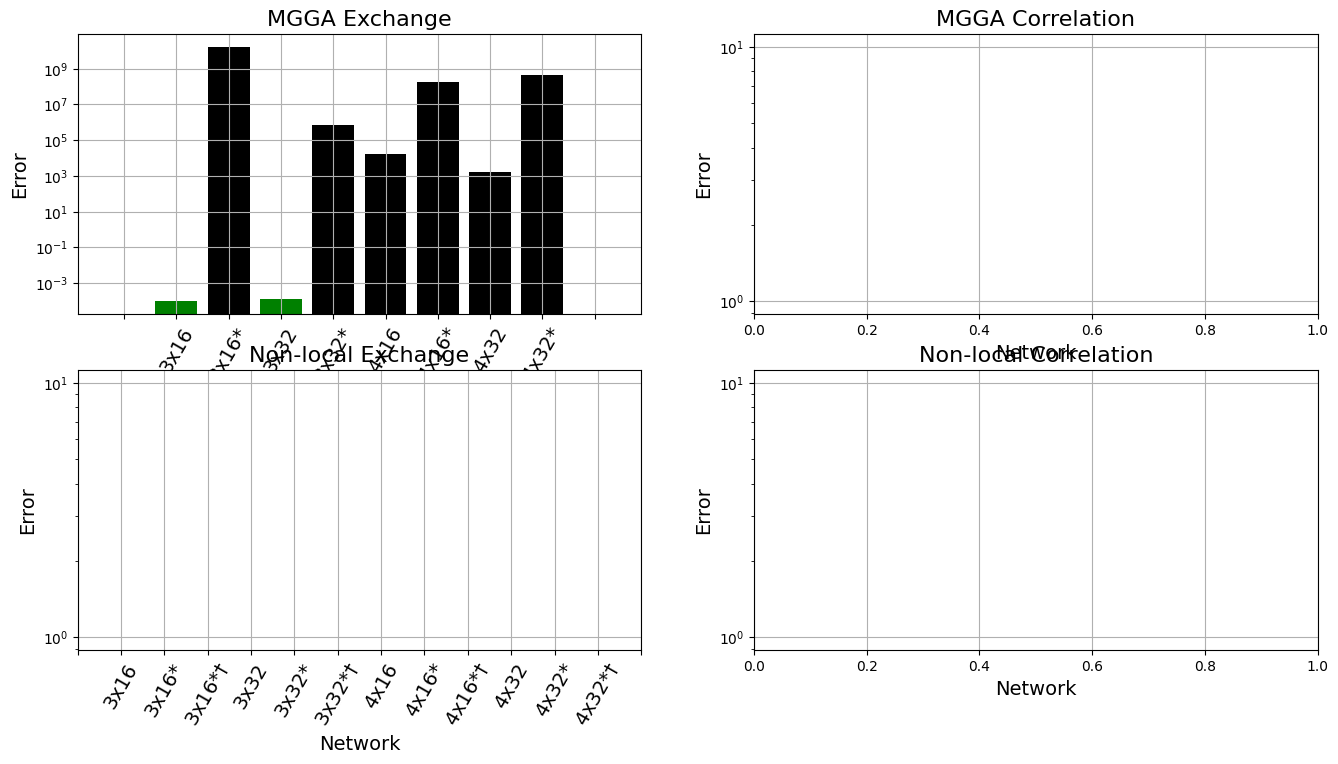

In [22]:
f = plt.figure(figsize=(16,8))

axxm = f.add_subplot(221)
axcm = f.add_subplot(222)
axxn = f.add_subplot(223)
axcn = f.add_subplot(224)
axs = [axxm, axcm, axxn, axcn]

axxm.set_title('MGGA Exchange', fontsize=16)
axcm.set_title('MGGA Correlation', fontsize=16)
axxn.set_title('Non-local Exchange', fontsize=16)
axcn.set_title('Non-local Correlation', fontsize=16)

for ax in axs:
    ax.grid()
    ax.set_xlabel('Network', fontsize=14)
    ax.set_ylabel('Error', fontsize=14)
    ax.set_yscale('log')
    # ax.set_ylim(0, 100)

PLOTXC = 'PBE0'

def get_label(net):
    nd_split = net.split('_')
    if len(nd_split) == 4:
        #xorc_depth_nodes_level    
        xorc, depth, nodes, level = nd_split
        lr2 = ''
        use = ''
    elif len(nd_split) == 5:
        #xorc_depth_nodes_level_lr2, just denotes a different learning rate schedule used    
        xorc, depth, nodes, level, lr2 = nd_split
        use = ''
    elif len(nd_split) == 6:
        #xorc_depth_nodes_level_lr2_use2, just denotes a different learning rate schedule used    
        xorc, depth, nodes, level, lr2, use = nd_split

    label = f'{depth}x{nodes}'
    if lr2:
        label+='*'
    if use:
        label+='$\dagger$'
    return label

#IMPORTANT: errors are MSE, NOT RMSE right now
for krefxc in val_dct.keys():
    if krefxc != PLOTXC:
        continue
    krefdct = val_dct[krefxc]
    for kxorc in krefdct.keys():
        krefxcdct = krefdct[kxorc]
        for klevel in krefxcdct.keys():
            krxcldct = krefxcdct[klevel]
            #DO GET_DATA GENERATION HERE
            data = []
            calcs = []
            rejects = []
            # tdrhos = [i[0] for i in data]
            # tfxcs = [i[1] for i in data]
            if kxorc == 'x':
                if klevel == 'mgga':
                    ax = axxm
                elif klevel == 'nl':
                    ax = axxn
            elif kxorc == 'c':
                if klevel == 'mgga':
                    ax = axcm
                elif klevel == 'nl':
                    ax = axcn
            knets = sorted(list(krxcldct.keys()))
            xs = np.arange(0, len(knets)+2)
            ax.set_xticks(xs)
            ax.set_xticklabels(['']+[get_label(i) for i in knets]+[''], fontsize=14, rotation=60)
            errors = []

            calcs = calc_dct[krefxc][kxorc][klevel]['calcs']
            rejects = calc_dct[krefxc][kxorc][klevel]['rejects']
            print(f'{krefxc}-{kxorc}-{klevel}: NCalcs = {len(calcs)}/NRejects = {len(rejects)}')
            for knet in knets:
                print(krefxc, kxorc, klevel, knet)
                #plot
                try:
                    tup = get_model_info(refxcps[krefxc], knet)
                except:
                    continue
                try:
                    errors.append(np.mean(krxcldct[knet]) ) 
                except:
                    errors.append(0)
            print(len(xs), len(errors))
            errors = np.array([0]+errors+[0])
            m1 = errors < 1
            ax.bar(xs[m1], errors[m1], facecolor='g')
            ax.bar(xs[~ m1], errors[~ m1], facecolor='k')
plt.tight_layout()

In [10]:
val_dct['PBE0']['x']['mgga']

{'x_3_16_mgga': [Array(0.00012691, dtype=float64),
  Array(7.47716586e-05, dtype=float64),
  Array(0.0001886, dtype=float64),
  Array(0.00016541, dtype=float64),
  Array(0.0001267, dtype=float64),
  Array(0.00010122, dtype=float64),
  Array(0.00014187, dtype=float64),
  Array(0.00010305, dtype=float64),
  Array(4.79771718e-05, dtype=float64),
  Array(0.00010595, dtype=float64),
  Array(8.13546688e-05, dtype=float64),
  Array(0.00010045, dtype=float64),
  Array(0.00044799, dtype=float64),
  Array(0.0001241, dtype=float64),
  Array(0.00011403, dtype=float64),
  Array(0.00013573, dtype=float64),
  Array(5.80103519e-05, dtype=float64),
  Array(0.00015147, dtype=float64),
  Array(9.28782769e-05, dtype=float64),
  Array(9.42883107e-05, dtype=float64),
  Array(0.00012057, dtype=float64),
  Array(6.54326011e-05, dtype=float64),
  Array(6.33216915e-05, dtype=float64),
  Array(0.00012217, dtype=float64),
  Array(0.00011282, dtype=float64),
  Array(0.00010678, dtype=float64),
  Array(0.0001449, d